In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from predict_test_data import predict_test_data

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [54]:
train = pd.read_csv('../data/cleaned/train_final.csv')
test = pd.read_csv('../data/cleaned/test_final.csv')

In [55]:
train.head()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,wins_past_1_games_diff,wins_home_against_away_4_games,score_past_1_games_diff,wins_past_3_games_diff,score_conceded_past_4_games_diff,score_conceded_past_5_games_diff,score_past_2_games_diff,wins_home_against_away_2_games,score_conceded_past_3_games_diff,score_conceded_past_2_games_diff
0,2006-09-01 00:00:00+00:00,Denmark,Portugal,4,2,Friendly,Denmark,False,-3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2006-09-02 00:00:00+00:00,Romania,Bulgaria,2,2,UEFA Euro qualification,Romania,False,-1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006-09-02 00:00:00+00:00,Poland,Finland,1,3,UEFA Euro qualification,Poland,False,-0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2006-09-02 00:00:00+00:00,Hungary,Norway,1,4,UEFA Euro qualification,Hungary,False,-7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-09-02 00:00:00+00:00,Germany,Ireland,1,0,UEFA Euro qualification,Germany,False,8.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.columns

Index(['game_date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'overall_diff',
       'attack_away_defence_home_diff', 'attack_diff',
       'attack_home_defence_away_diff', 'defence_diff', 'midfield_diff',
       'rank_diff', 'prestige_diff', 'growth_diff', 'full_age_diff',
       'start_age_diff', 'value_euros_millions_diff',
       'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
       'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
       'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
       'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 'home_win',
       'gdp_diff', 'is_home', 'raw_gdp_diff', 'score_past_3_games_diff',
       'wins_past_5_games_diff', 'wins_home_against_away_3_games',
       'score_past_4_games_diff', 'wins_home_against_away_1_games',
       'score_past_5_games_diff', 'score_conceded_past_1_games_diff',
       'wins_past_4_games_diff', 'wins_past_2_games_diff',
       'w

## Advanced Model

For the advanced model, let us start with all the collected data that we currently have. We can then subsequently do some variable selection to select a smaller subset of predictors if necessary. 

In [56]:
columns = ['overall_diff', 'attack_away_defence_home_diff', 'attack_diff',
           'defence_diff', 'midfield_diff',
           'prestige_diff', 'growth_diff', 'full_age_diff',
           'start_age_diff', 'value_euros_millions_diff',
           'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
           'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
           'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
           'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 'home_win',
           'gdp_diff', 'is_home', 'raw_gdp_diff']


In [57]:
train = train[columns]
test = test[columns + ['Group']]

In [77]:
#Same seed as baseline to ensure same train and validation sets so that comparisons are valid.
#10
np.random.seed(14)
X_train, X_valid = train_test_split(train, test_size = 0.2)
y_train = X_train['home_win'].ravel()
X_train = X_train.drop(['home_win'], axis = 1)
y_valid= X_valid['home_win'].ravel()
X_valid = X_valid.drop(['home_win'], axis = 1)
y_test = test['home_win'].ravel()


# collect group
grp = test['Group'].ravel()
grp_id = [0 if len(i) == 1 else 1 for i in grp]
X_test = test.drop(['home_win', 'Group'], axis = 1)



In [78]:
# stores the score of each model
score = {}

## Principal Components Regression

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [80]:
# get column names
predictors = X_train.columns.values

# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


# PCA on data
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

In [81]:
# full components
pcr_mod = LogisticRegressionCV(solver = 'lbfgs', 
                               max_iter = 5000, 
                               cv = 5, 
                               multi_class='multinomial').fit(X_train_pca, y_train)

In [82]:
# test set
X_test_pca = pca.transform(X_test_scaled)

pcr_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i==1) & (np.argmax(val) == 1)
                 else np.argmax(val)-1 for i, val in zip(grp_id, pcr_mod.predict_proba(X_test_pca))]

In [83]:
score["pcr_full"] = {}
score["pcr_full"]["model"] = pcr_mod
score["pcr_full"]["Train Score"] = pcr_mod.score(X_train_pca, y_train)
score["pcr_full"]["Validation Score"] = pcr_mod.score(X_valid_pca, y_valid)
score["pcr_full"]["Test Score"] = accuracy_score(y_test, pcr_test_pred)
print("PCR (Full) Train Score: {}".format(score["pcr_full"]["Train Score"]))
print("PCR (Full) Validation Score: {}".format(score["pcr_full"]["Validation Score"]))
print("PCR (Full) Test Score: {}".format(score["pcr_full"]["Test Score"]))

PCR (Full) Train Score: 0.5102175346077785
PCR (Full) Validation Score: 0.5394736842105263
PCR (Full) Test Score: 0.59375


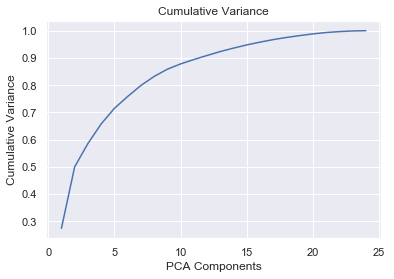

In [84]:
pca_cumvar = np.cumsum(pca.explained_variance_ratio_) 

plt.plot(np.arange(1,len(pca_cumvar)+1), pca_cumvar)
plt.title('Cumulative Variance')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Variance');

In [86]:
pca80_com = np.argmax(pca_cumvar >= 0.8)+1
pca90_com = np.argmax(pca_cumvar >= 0.9)+1

print('Number of Components to explain 80% Variance: {}'.format(pca80_com))
print('Number of Components to explain 90% Variance: {}'.format(pca90_com))

Number of Components to explain 80% Variance: 8
Number of Components to explain 90% Variance: 12


In [87]:
# 80% variation
pca80 = PCA(n_components=pca80_com).fit(X_train_scaled)
X_train_pca80 = pca80.transform(X_train_scaled)
X_valid_pca80 = pca80.transform(X_valid_scaled)

# 90% variation
pca90 = PCA(n_components=pca90_com).fit(X_train_scaled)
X_train_pca90 = pca90.transform(X_train_scaled)
X_valid_pca90 = pca90.transform(X_valid_scaled)

# fit models
pcr80_mod = LogisticRegressionCV(solver = 'lbfgs', 
                               max_iter = 5000, 
                               cv = 5, 
                               multi_class='multinomial').fit(X_train_pca80, y_train)
pcr90_mod = LogisticRegressionCV(solver = 'lbfgs', 
                               max_iter = 5000, 
                               cv = 5, 
                               multi_class='multinomial').fit(X_train_pca90, y_train)

In [88]:
# test set
# 80% variation
X_test_pca80 = pca80.transform(X_test_scaled)

pcr80_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i==1) & (np.argmax(val) == 1)
                   else np.argmax(val)-1 for i, val in zip(grp_id, pcr80_mod.predict_proba(X_test_pca80))]

# 90% variation
X_test_pca90 = pca90.transform(X_test_scaled)

pcr90_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i==1) & (np.argmax(val) == 1)
                   else np.argmax(val)-1 for i, val in zip(grp_id, pcr90_mod.predict_proba(X_test_pca90))]

In [89]:
# 80% variation
score["pcr_80%"] = {}
score["pcr_80%"]["model"] = pcr80_mod
score["pcr_80%"]["Train Score"] = pcr80_mod.score(X_train_pca80, y_train)
score["pcr_80%"]["Validation Score"] = pcr80_mod.score(X_valid_pca80, y_valid)
score["pcr_80%"]["Test Score"] = accuracy_score(y_test, pcr80_test_pred)
print("PCR (80%) Train Score: {}".format(score["pcr_80%"]["Train Score"]))
print("PCR (80%) Validation Score: {}".format(score["pcr_80%"]["Validation Score"]))
print("PCR (80%) Test Score: {}".format(score["pcr_80%"]["Test Score"]))

# 90% variation
score["pcr_90%"] = {}
score["pcr_90%"]["model"] = pcr90_mod
score["pcr_90%"]["Train Score"] = pcr90_mod.score(X_train_pca90, y_train)
score["pcr_90%"]["Validation Score"] = pcr90_mod.score(X_valid_pca90, y_valid)
score["pcr_90%"]["Test Score"] = accuracy_score(y_test, pcr90_test_pred)
print("PCR (90%) Train Score: {}".format(score["pcr_90%"]["Train Score"]))
print("PCR (90%) Test Score: {}".format(score["pcr_90%"]["Test Score"]))

PCR (80%) Train Score: 0.5168094924192486
PCR (80%) Validation Score: 0.5394736842105263
PCR (80%) Test Score: 0.625
PCR (90%) Train Score: 0.5102175346077785
PCR (90%) Test Score: 0.65625


Rather than using arbitrary markers for the cumulative percentage of variation captured by our PCA, we can check for the most ideal number of components for our regression as well.

In [90]:
pcr_train_score = []
pcr_valid_score = []
pcr_test_score = []

for i in np.arange(1, X_train.shape[1]):
    pca_cv = PCA(n_components=i).fit(X_train_scaled)
    X_train_pca_cv = pca_cv.transform(X_train_scaled)
    X_valid_pca_cv = pca_cv.transform(X_valid_scaled)
    X_test_pca_cv = pca_cv.transform(X_test_scaled)
    
    pcr_cv_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                      max_iter = 5000, 
                                      cv = 5, 
                                      multi_class='multinomial').fit(X_train_pca_cv, y_train)
    
    pcr_train_score.append(pcr_cv_mod.score(X_train_pca_cv, y_train))
    pcr_valid_score.append(pcr_cv_mod.score(X_valid_pca_cv, y_valid))
    
    pcr_test_score.append(accuracy_score(y_test,
              [np.where(np.argsort(val) == 1)[0][0]-1 if (i==1) & (np.argmax(val) == 1)
               else np.argmax(val)-1 for i, val in zip(grp_id, pcr_cv_mod.predict_proba(X_test_pca_cv))]))
#     pcr_test_score.append(pcr_cv_mod.score(X_test_pca_cv, y_test))

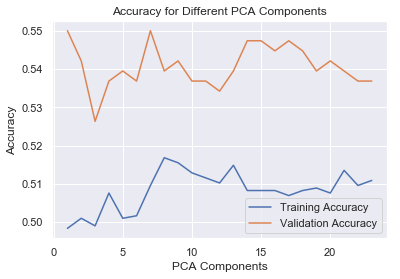

In [91]:
plt.plot(np.arange(1,len(pcr_train_score)+1), pcr_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(pcr_valid_score)+1), pcr_valid_score, label='Validation Accuracy')


plt.title('Accuracy for Different PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.legend();

In [92]:
# maybe we can do something subsequently to test for all highest validation accuracies
# because np.argmax() randomly picks if there are multiple max
pca_best_com = np.argmax(pcr_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(pca_best_com))

Best Validation Accuracy Number of Components: 1


In [93]:
# best mod with highest validation accuracy
pca_best = PCA(n_components=pca_best_com).fit(X_train_scaled)
X_train_pca_best = pca_best.transform(X_train_scaled)
X_valid_pca_best = pca_best.transform(X_valid_scaled)

# fit models
pcr_best_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                    max_iter = 5000, 
                                    cv = 5, 
                                    multi_class='multinomial').fit(X_train_pca_best, y_train)

In [95]:
# test set
X_test_pca_best = pca_best.transform(X_test_scaled)

pcr_best_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i==1) & (np.argmax(val) == 1)
                      else np.argmax(val)-1 for i, val in zip(grp_id, pcr_best_mod.predict_proba(X_test_pca_best))]


In [104]:
# Best Validation Accuracy
score["pcr_best"] = {}
score["pcr_best"]["model"] = pcr_best_mod
score["pcr_best"]["Train Score"] = pcr_best_mod.score(X_train_pca_best, y_train)
score["pcr_best"]["Validation Score"] = pcr_best_mod.score(X_valid_pca_best, y_valid)
score["pcr_best"]["Test Score"] = accuracy_score(y_test, pcr_best_test_pred)
print("PCR (Best) Train Score: {}".format(score["pcr_best"]["Train Score"]))
print("PCR (Best) Validation Score: {}".format(score["pcr_best"]["Validation Score"]))
print("PCR (Best) Test Score: {}".format(score["pcr_best"]["Test Score"]))

PCR (Best) Train Score: 0.4983520105471325
PCR (Best) Validation Score: 0.55
PCR (Best) Test Score: 0.609375


Note that in this case, the best number of components for our validation set is not the best number of components for our test set.

## Partial Least Square Discriminant Analysis

Extending from PCR, we can try out PLS-DA as well to better account for the variation between predictors in relation to the response variable.

In [98]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)

In [102]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score

plsda_train_score = []
plsda_valid_score = []

for i in np.arange(1, X_train.shape[1]):
    plsda_mod = PLSRegression(n_components=i, scale=False) 
    plsda_mod.fit(X_train_scaled, y_train_lb)

    plsda_train_score.append(accuracy_score(y_train, np.argmax(plsda_mod.predict(X_train_scaled), axis=1) - 1))
    plsda_valid_score.append(accuracy_score(y_valid, np.argmax(plsda_mod.predict(X_valid_scaled), axis=1) - 1))

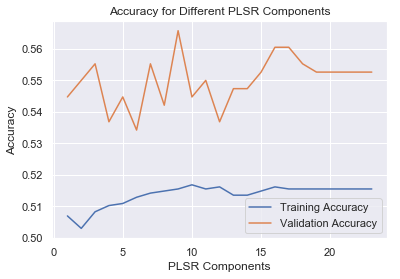

In [100]:
plt.plot(np.arange(1,len(plsr_train_score)+1), plsr_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(plsr_valid_score)+1), plsr_valid_score, label='Validation Accuracy')

plt.title('Accuracy for Different PLSR Components')
plt.xlabel('PLSR Components')
plt.ylabel('Accuracy')
plt.legend();

In [101]:
plsr_best_com = np.argmax(plsr_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(plsr_best_com))

Best Validation Accuracy Number of Components: 9


In [103]:
# check test accuracy
plsda_best_mod = PLSRegression(n_components=plsr_best_com, scale=False) 
plsda_best_mod.fit(X_train_scaled, y_train_lb)

plsda_best_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i==1) & (np.argmax(val) == 1) 
                       else np.argmax(val)-1 for i, val in zip(grp_id, plsda_best_mod.predict(X_test_scaled))]


In [105]:
# Best Validation Accuracy
score["plsda_best"] = {}
score["plsda_best"]["model"] = plsda_best_mod
score["plsda_best"]["Train Score"] = accuracy_score(y_train, np.argmax(plsda_mod.predict(X_train_scaled), axis=1) - 1)
score["plsda_best"]["Validation Score"] = accuracy_score(y_valid, np.argmax(plsda_mod.predict(X_valid_scaled), axis=1) - 1)
score["plsda_best"]["Test Score"] = accuracy_score(y_test, plsda_best_test_pred)
print("PLS-DA (Best) Train Score: {}".format(score["plsda_best"]["Train Score"]))
print("PLS-DA (Best) Validation Score: {}".format(score["plsda_best"]["Validation Score"]))
print("PLS-DA (Best) Test Score: {}".format(score["plsda_best"]["Test Score"]))

PLS-DA (Best) Train Score: 0.5154911008569545
PLS-DA (Best) Validation Score: 0.5526315789473685
PLS-DA (Best) Test Score: 0.671875


In [106]:
plsr_test_score = []

for i in np.arange(1, X_train.shape[1]):
    plsr_mod = PLSRegression(n_components=i, scale=False)
    plsr_mod.fit(X_train_scaled, y_train_lb)
    test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i==1) & (np.argmax(val) == 1) 
                 else np.argmax(val)-1 for i, val in zip(grp_id, plsr_mod.predict(X_test_scaled))]
    plsr_test_score.append(accuracy_score(y_test, test_pred))

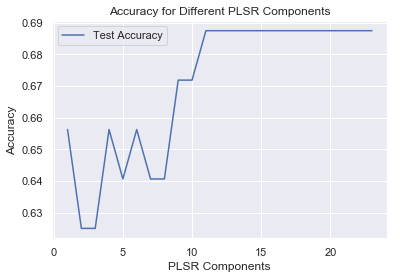

In [107]:
plt.plot(np.arange(1,len(plsr_test_score)+1), plsr_test_score, label='Test Accuracy')

plt.title('Accuracy for Different PLSR Components')
plt.xlabel('PLSR Components')
plt.ylabel('Accuracy')
plt.legend();

Note that the best number of components for our validation set is the best number of components for our test set as well.